## 19/02/2019

- Only augmenting fractionated segments

In [198]:
# Import necessary modules. Set settings. Import data.
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from epdata_tools import epdata_main, get_ep_features, get_ep_feature_dict
from IPython.display import HTML

from Augmentation import data_augmentation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import svm, naive_bayes, neighbors, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process.kernels import RBF

import xgboost

from IPython.display import display, clear_output
import pdb

plt.style.use('default')

X_compact = pd.read_pickle('/Users/matthewashman/github/MasterProject2018/Data/X_af_compact.pkl')

## Data Format
Each row corresponds to a patient's response to either an S1 or S2 pulse. The coupling interval and patient indicate which file the data was extracted from.

In [199]:
X_compact.head()

,CS1-2,CS3-4,CS5-6,CS7-8,Coupling Interval,Label,Patient,S1/S2,Type
0,"[-903.0, -873.0, -935.0, -941.0, -910.0, -845....","[298.0, 292.0, 303.0, 311.0, 299.0, 395.0, 451...","[1776.0, 2220.0, 1790.0, -4058.0, -15027.0, -2...","[6283.0, 6464.0, 5952.0, 4507.0, 3694.0, 2873....",340,NaN,1,S1,af
1,"[-931.0, -896.0, -896.0, -906.0, -858.0, -839....","[339.0, 328.0, 348.0, 328.0, 299.0, 361.0, 349...","[1678.0, 2049.0, 2080.0, -1681.0, -11648.0, -1...","[6161.0, 6208.0, 5897.0, 4703.0, 3732.0, 2980....",340,NaN,1,S1,af
2,"[-931.0, -896.0, -896.0, -906.0, -858.0, -839....","[339.0, 328.0, 348.0, 328.0, 299.0, 361.0, 349...","[1678.0, 2049.0, 2080.0, -1681.0, -11648.0, -1...","[6161.0, 6208.0, 5897.0, 4703.0, 3732.0, 2980....",340,NaN,1,S1,af
3,"[-985.0, -925.0, -943.0, -919.0, -935.0, -877....","[255.0, 287.0, 321.0, 335.0, 396.0, 400.0, 491...","[2053.0, 2296.0, -448.0, -11020.0, -19196.0, -...","[5944.0, 5725.0, 4579.0, 3615.0, 2952.0, 1393....",330,NaN,1,S1,af
4,"[-1025.0, -913.0, -885.0, -903.0, -864.0, -947...","[262.0, 285.0, 336.0, 349.0, 342.0, 490.0, 506...","[1726.0, 2111.0, 2289.0, -736.0, -11322.0, -19...","[6270.0, 6584.0, 6191.0, 4876.0, 3749.0, 2986....",330,NaN,1,S1,af


## Data Augmentation
As the dataset is very asymetric (many more non-fractionated examples), here I augmented more fractionated examples as described in my technical milestone report. I have found that this improves classification performance very significantly - especially in reducing the number of false negatives (i.e. fractionated responses being predicted as non-fractionated).

In [200]:
# %matplotlib qt 
# Create new augmented data for each S2 row of X_compact
X_compact['Augmented'] = 0
# Use for storing augmented_rows in the form of dicts
augmented_list = []
for _, row in X_compact[(X_compact['S1/S2']=='S2') & (X_compact['Label']==1)].iterrows():
    
    augmented_row = {}
    augmented_cs12 = data_augmentation.augment_fractionation(row['CS1-2'], 3, False)
    augmented_cs34 = data_augmentation.augment_fractionation(row['CS3-4'], 3, False)
    augmented_cs56 = data_augmentation.augment_fractionation(row['CS5-6'], 3, False)
    for cs12, cs34, cs56 in zip(augmented_cs12, augmented_cs34, augmented_cs56):
        augmented_row = {}
        augmented_row['CS1-2'] = cs12
        augmented_row['CS3-4'] = cs34
        augmented_row['CS5-6'] = cs56
        augmented_row['CS7-8'] = row['CS7-8']
        augmented_row['Coupling Interval'] = row['Coupling Interval']
        augmented_row['Label'] = row['Label']
        augmented_row['Patient'] = row['Patient']
        augmented_row['S1/S2'] = row['S1/S2']
        augmented_row['Type'] = row['Type']
        augmented_row['Augmented'] = 1
        augmented_list.append(augmented_row)
        
# for _, row in X_compact[(X_compact['S1/S2']=='S2') & (X_compact['Label']==0)].iterrows():
    
#     augmented_row = {}
#     augmented_cs12 = data_augmentation.augment_fractionation(row['CS1-2'], 1, False)
#     augmented_cs34 = data_augmentation.augment_fractionation(row['CS3-4'], 1, False)
#     augmented_cs56 = data_augmentation.augment_fractionation(row['CS5-6'], 1, False)
#     for cs12, cs34, cs56 in zip(augmented_cs12, augmented_cs34, augmented_cs56):
#         augmented_row = {}
#         augmented_row['CS1-2'] = cs12
#         augmented_row['CS3-4'] = cs34
#         augmented_row['CS5-6'] = cs56
#         augmented_row['CS7-8'] = row['CS7-8']
#         augmented_row['Coupling Interval'] = row['Coupling Interval']
#         augmented_row['Label'] = row['Label']
#         augmented_row['Patient'] = row['Patient']
#         augmented_row['S1/S2'] = row['S1/S2']
#         augmented_row['Type'] = row['Type']
#         augmented_row['Augmented'] = 1
#         augmented_list.append(augmented_row)
    
#     fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,8))
#     axes[0][0].plot(row['CS1-2'])
#     axes[0][0].set_title('Original CS1-2')
#     axes[0][1].plot(augmented_row['CS1-2'][0])
#     axes[0][1].set_title('Augmented CS1-2')
#     axes[1][0].plot(row['CS3-4'])
#     axes[1][0].set_title('Original CS3-4')
#     axes[1][1].plot(augmented_row['CS3-4'][0])
#     axes[1][1].set_title('Augmented CS3-4')
#     axes[2][0].plot(row['CS5-6'])
#     axes[2][0].set_title('Original CS5-6')
#     axes[2][1].plot(augmented_row['CS5-6'][0])
#     axes[2][1].set_title('Augmented CS5-6')
    
#     plt.draw()
#     plt.waitforbuttonpress()
#     plt.close()
    

augmented_data = pd.DataFrame(augmented_list)
X_all = pd.concat([X_compact, augmented_data], ignore_index=True)

In [201]:
print(X_compact.shape[0])
print(X_all.shape[0])

452
545


## Feature Extraction
Here the feature vectors are extracted for each row S2 response (including the augmented responses). A reference feature vector is subtracted (as described - the first S1 response of the patient (i.e. in the file with the largest S1/S2 coupling interval) is extracted and the feature vector calculated. This is subtracted from all feature vectors corresponding to all other S2 responses for that patient).

In [202]:
# of the four segments in CS1-2, CS3-4 and CS5-6.
X_feature_dicts = []
for i, row in X_all[X_all['S1/S2']=='S2'].iterrows():
    clear_output(wait=True)
    display('Extracting Features: ' + str(round(100*i/X_all[(X_all['S1/S2']=='S2')].index[-1],3)) + '%')
    
    dicts = []
    ref_dicts = []
    ref = X_all[(X_all['S1/S2']=='S1') & (X_all['Patient']==row['Patient'])].sort_values(by=['Coupling Interval'], ascending=False).iloc[0]
    dicts.append(get_ep_feature_dict(row['CS1-2'], 'CS1-2'))
    ref_dicts.append(get_ep_feature_dict(ref['CS1-2'], 'CS1-2'))
    dicts.append(get_ep_feature_dict(row['CS3-4'], 'CS3-4'))
    ref_dicts.append(get_ep_feature_dict(ref['CS3-4'], 'CS3-4'))
    dicts.append(get_ep_feature_dict(row['CS5-6'], 'CS5-6'))
    ref_dicts.append(get_ep_feature_dict(ref['CS5-6'], 'CS5-6'))
    
    feature_dict = {}
    for d, d_ref in zip(dicts, ref_dicts):
        for k, v in d.items():
            feature_dict[k] = v - d_ref.get(k)
        
    feature_dict['Type'] = row['Type']
    feature_dict['Patient'] = row['Patient']
    feature_dict['Coupling Interval'] = row['Coupling Interval']
    feature_dict['Label'] = row['Label'] 
    feature_dict['Augmented'] = row['Augmented']
#     for d in dicts:
#         for k, v in d.items():
#             feature_dict[k] = v 
            
    X_feature_dicts.append(feature_dict)
    
X_features = pd.DataFrame(X_feature_dicts)

'Extracting Features: 100.0%'

In [203]:
# Perform training test split on patients. i.e., 3 patients in the test set and 7 in training.
patient_nums = list(range(1,11))
patient_nums.remove(7) # Forget patient 7 for now
random.shuffle(patient_nums)

test_patients = patient_nums[-3:]
training_patients = patient_nums[:7]
training_patients = [str(x) for x in training_patients]
test_patients = [str(x) for x in test_patients]
print(training_patients)
print(test_patients)

['1', '9', '6', '8', '4', '2', '5']
['5', '3', '10']


In [204]:
X_training = X_features[X_features['Patient'].isin(training_patients)].drop(['Label', 'Patient', 'Type', 'Coupling Interval', 'Augmented'], axis=1)
y_training = X_features[X_features['Patient'].isin(training_patients)]['Label']
info_training = X_features[X_features['Patient'].isin(training_patients)][['Label', 'Patient', 'Type', 'Coupling Interval', 'Augmented']]


X_test = X_features[X_features['Patient'].isin(test_patients)].drop(['Label', 'Patient', 'Type', 'Coupling Interval', 'Augmented'], axis=1)
y_test = X_features[X_features['Patient'].isin(test_patients)]['Label']
info_test = X_features[X_features['Patient'].isin(test_patients)][['Label', 'Patient', 'Type', 'Coupling Interval', 'Augmented']]

# Remove augmented data from test set.
X_test_real = X_features[(X_features['Patient'].isin(test_patients)) & (X_features['Augmented'] == 0)].drop(['Label', 'Patient', 'Type', 'Coupling Interval', 'Augmented'], axis=1)
y_test_real = X_features[(X_features['Patient'].isin(test_patients)) & (X_features['Augmented'] == 0)]['Label']
info_test_real = X_features[(X_features['Patient'].isin(test_patients)) & (X_features['Augmented'] == 0)][['Label', 'Patient', 'Type', 'Coupling Interval', 'Augmented']]

In [205]:
X_test.shape[0]

86

In [206]:
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t/p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

## Results of Classifiers on Augmented data
By creating augmented fractionated examples, the XGBoost classifier's false negative rate improves significantly! Other classifiers are unable to distinginguish between the examples.

In [207]:
# Get cross validation scores on training data, following by test score.
import warnings
warnings.filterwarnings('ignore')

models = (LogisticRegression(penalty='l1', C=1, random_state=0, solver='liblinear'), 
          svm.SVC(), 
          svm.LinearSVC(penalty='l1', C=1, dual=False),
          naive_bayes.GaussianNB(), 
          neighbors.KNeighborsClassifier(), 
          gaussian_process.GaussianProcessClassifier(kernel=1.0*RBF(1)), 
          xgboost.XGBClassifier())
model_names = ('Logistic Regression', 'RBF SVC', 'Linear SVC', 'Naive Bayes', 'KNN', 'GP', 'XGBoost')

print('Cross validation scores:')
for clf, model_name in zip(models, model_names):
    print(model_name)
    print(cross_val_score(clf, X_training.values, y_training.values, cv=3))
    
print('~~~~~~~~~~~~~~~~~~')
print('Cross validation scores with feature selection:')
for clf, model_name in zip(models, model_names):
    print(model_name)
    try:
        sfm = SelectFromModel(clf, threshold=0.1)
        sfm.fit(X_training.values, y_training.values)
        X_training_sparse = sfm.transform(X_training.values)
        print('Number of features selected: ' + str(X_training_sparse.shape[1]))
        print(cross_val_score(clf, X_training_sparse, y_training.values, cv=3))
    except ValueError:
        print("no 'coef_' or 'feature_importance_' attribute")

print('~~~~~~~~~~~~~~~~~~')
print('\nTest scores including augmented data:')
for clf, model_name in zip(models, model_names):
    clf.fit(X_training.values, y_training.values)
    print(model_name)
    print(clf.score(X_test.values, y_test.values))
    predictions = clf.predict(X_test.values)
    cm = confusion_matrix(y_test, predictions)
    print_cm(cm, ['Not Fractionated','Fractionated'])
    info_test[model_name + ' Predictions'] = predictions
    
print('~~~~~~~~~~~~~~~~~~')
print('\nTest scores on only real data:')
for clf, model_name in zip(models, model_names):
    clf.fit(X_training.values, y_training.values)
    print(model_name)
    print(clf.score(X_test_real.values, y_test_real.values))
    predictions_real = clf.predict(X_test_real.values)
    cm = confusion_matrix(y_test_real, predictions_real)
    print_cm(cm, ['Not Fractionated','Fractionated'])
    info_test_real[model_name + ' Predictions'] = predictions_real

Cross validation scores:
Logistic Regression
[0.64150943 0.86538462 0.82692308]
RBF SVC
[0.56603774 0.55769231 0.55769231]
Linear SVC
[0.62264151 0.94230769 0.75      ]
Naive Bayes
[0.90566038 0.94230769 0.90384615]
KNN
[0.66037736 0.75       0.59615385]
GP
[0.43396226 0.44230769 0.44230769]
XGBoost
[0.64150943 0.92307692 0.90384615]
~~~~~~~~~~~~~~~~~~
Cross validation scores with feature selection:
Logistic Regression
Number of features selected: 5
[0.73584906 0.98076923 0.92307692]
RBF SVC
no 'coef_' or 'feature_importance_' attribute
Linear SVC
Number of features selected: 8
[0.69811321 0.98076923 0.94230769]
Naive Bayes
no 'coef_' or 'feature_importance_' attribute
KNN
no 'coef_' or 'feature_importance_' attribute
GP
no 'coef_' or 'feature_importance_' attribute
XGBoost
Number of features selected: 4
[0.64150943 0.88461538 0.90384615]
~~~~~~~~~~~~~~~~~~

Test scores including augmented data:
Logistic Regression
0.9651162790697675
           t/p       Not Fractionated     Fractionat

In [107]:
feature_names = X_test.columns
# Separating out the features
x = X_test.loc[:, feature_names].values
x_real = X_test_real.loc[:, feature_names].values

# Separating out the labels
labels = info_test.loc[:,['Label']].values
labels_real = info_test_real.loc[:,['Label']].values


# Seperating out the predicitons
predictions = info_test.loc[:, ['XGBoost Predictions']]
predictions_real = info_test_real.loc[:, ['XGBoost Predictions']]

# Standardizing the features
x = StandardScaler().fit_transform(x)
x_real = StandardScaler().fit_transform(x_real)

In [108]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principal_components
             , columns = ['principal component 1', 'principal component 2'])

final_df = pd.concat([principal_df, info_test.reset_index()], axis = 1)

pca_real = PCA(n_components=2)
principal_components_real = pca.fit_transform(x_real)
principal_df_real = pd.DataFrame(data = principal_components_real
             , columns = ['principal component 1', 'principal component 2'])

final_df_real = pd.concat([principal_df_real, info_test_real.reset_index()], axis = 1)

In [109]:
final_df.head()

,principal component 1,principal component 2,index,Label,Patient,Type,Coupling Interval,Augmented,SVM Predictions,Naive Bayes Predictions,KNN Predictions,GP Predictions,XGBoost Predictions
0,3.939198,-1.269879,43,0.0,4,af,340,0,1.0,0.0,1.0,0.0,0.0
1,3.673622,-1.941577,44,0.0,4,af,330,0,1.0,0.0,0.0,0.0,0.0
2,3.873013,-1.888878,45,0.0,4,af,320,0,1.0,0.0,1.0,0.0,0.0
3,3.965131,-1.775633,46,0.0,4,af,310,0,1.0,0.0,0.0,0.0,0.0
4,3.808105,-1.661518,47,0.0,4,af,300,0,1.0,0.0,0.0,0.0,0.0


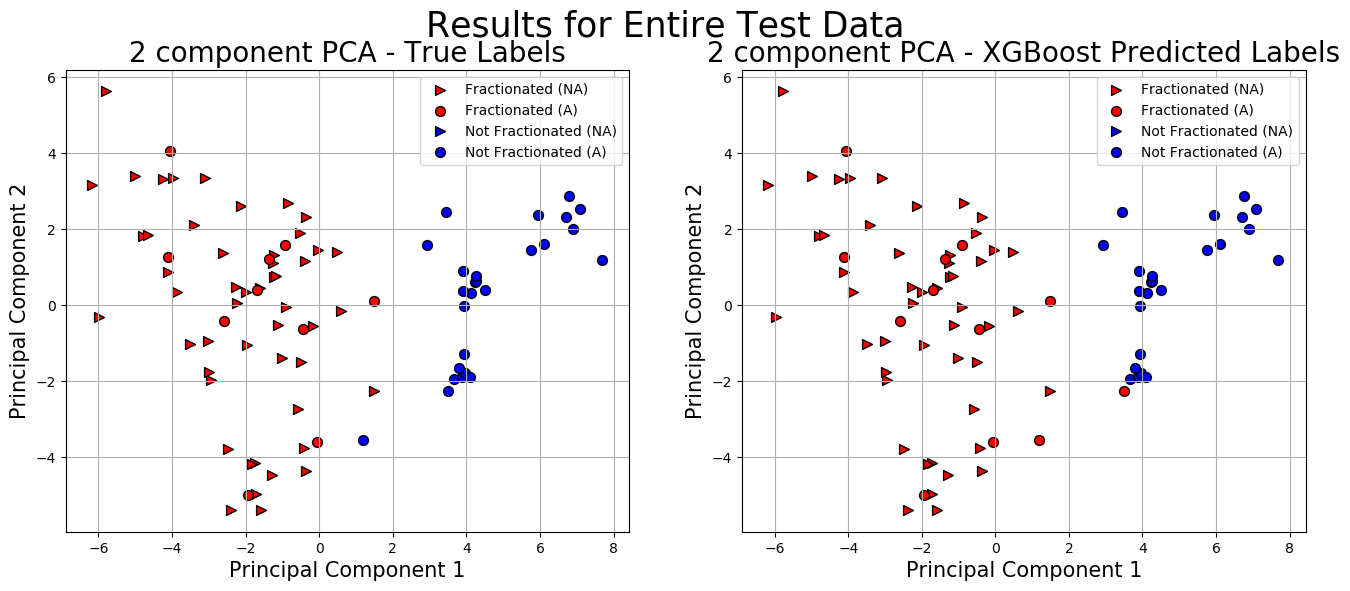

In [110]:
fig = plt.figure(figsize = (16,6))
ax1 = fig.add_subplot(1,2,1) 
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_title('2 component PCA - True Labels', fontsize = 20)
labels = [1, 0]
colors = ['r', 'b']
augmented = [1,0]
markers = ['o', '>']
for label, color in zip(labels,colors):
    for aug in augmented:
        idx_to_keep = ((final_df['Label'].values == label) & (final_df['Augmented'] == aug))
        ax1.scatter(final_df.loc[idx_to_keep, 'principal component 1']
                   , final_df.loc[idx_to_keep, 'principal component 2']
                   , c = color
                   , marker = markers[aug]
                   , edgecolors = 'k'
                   , s = 50)
ax1.legend(['Fractionated (NA)', 'Fractionated (A)', 
            'Not Fractionated (NA)', 'Not Fractionated (A)'])
ax1.grid()

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel('Principal Component 1', fontsize = 15)
ax2.set_ylabel('Principal Component 2', fontsize = 15)
ax2.set_title('2 component PCA - XGBoost Predicted Labels', fontsize = 20)
predictions = [1, 0]
colors = ['r', 'b']

for prediction, color in zip(predictions,colors):
    for aug in augmented:
        idx_to_keep = ((final_df['XGBoost Predictions'].values == prediction) & (final_df['Augmented'] == aug))
        ax2.scatter(final_df.loc[idx_to_keep, 'principal component 1']
                   , final_df.loc[idx_to_keep, 'principal component 2']
                   , c = color
                   , marker = markers[aug]
                   , edgecolors = 'k'
                   , s = 50)
ax2.legend(['Fractionated (NA)', 'Fractionated (A)', 
            'Not Fractionated (NA)', 'Not Fractionated (A)'])
ax2.grid()

plt.suptitle('Results for Entire Test Data', fontsize=25)
plt.show()

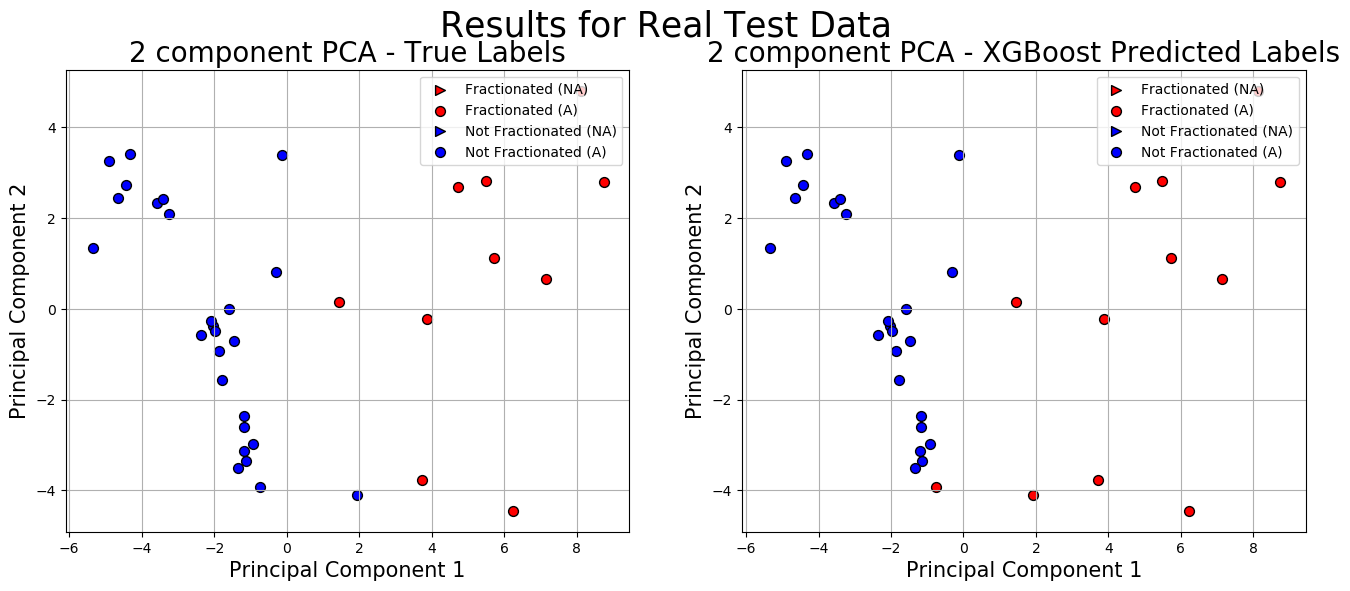

In [111]:
fig = plt.figure(figsize = (16,6))
ax1 = fig.add_subplot(1,2,1) 
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_title('2 component PCA - True Labels', fontsize = 20)
labels = [1, 0]
colors = ['r', 'b']
augmented = [1,0]
markers = ['o', '>']
for label, color in zip(labels,colors):
    for aug in augmented:
        idx_to_keep = ((final_df_real['Label'].values == label) & (final_df_real['Augmented'] == aug))
        ax1.scatter(final_df_real.loc[idx_to_keep, 'principal component 1']
                   , final_df_real.loc[idx_to_keep, 'principal component 2']
                   , c = color
                   , marker = markers[aug]
                   , edgecolors = 'k'
                   , s = 50)
ax1.legend(['Fractionated (NA)', 'Fractionated (A)', 
            'Not Fractionated (NA)', 'Not Fractionated (A)'])
ax1.grid()

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel('Principal Component 1', fontsize = 15)
ax2.set_ylabel('Principal Component 2', fontsize = 15)
ax2.set_title('2 component PCA - XGBoost Predicted Labels', fontsize = 20)
predictions = [1, 0]
colors = ['r', 'b']

for prediction, color in zip(predictions,colors):
    for aug in augmented:
        idx_to_keep = ((final_df_real['XGBoost Predictions'].values == prediction) & (final_df_real['Augmented'] == aug))
        ax2.scatter(final_df_real.loc[idx_to_keep, 'principal component 1']
                   , final_df_real.loc[idx_to_keep, 'principal component 2']
                   , c = color
                   , marker = markers[aug]
                   , edgecolors = 'k'
                   , s = 50)
ax2.legend(['Fractionated (NA)', 'Fractionated (A)', 
            'Not Fractionated (NA)', 'Not Fractionated (A)'])
ax2.grid()

plt.suptitle('Results for Real Test Data', fontsize=25)
plt.show()

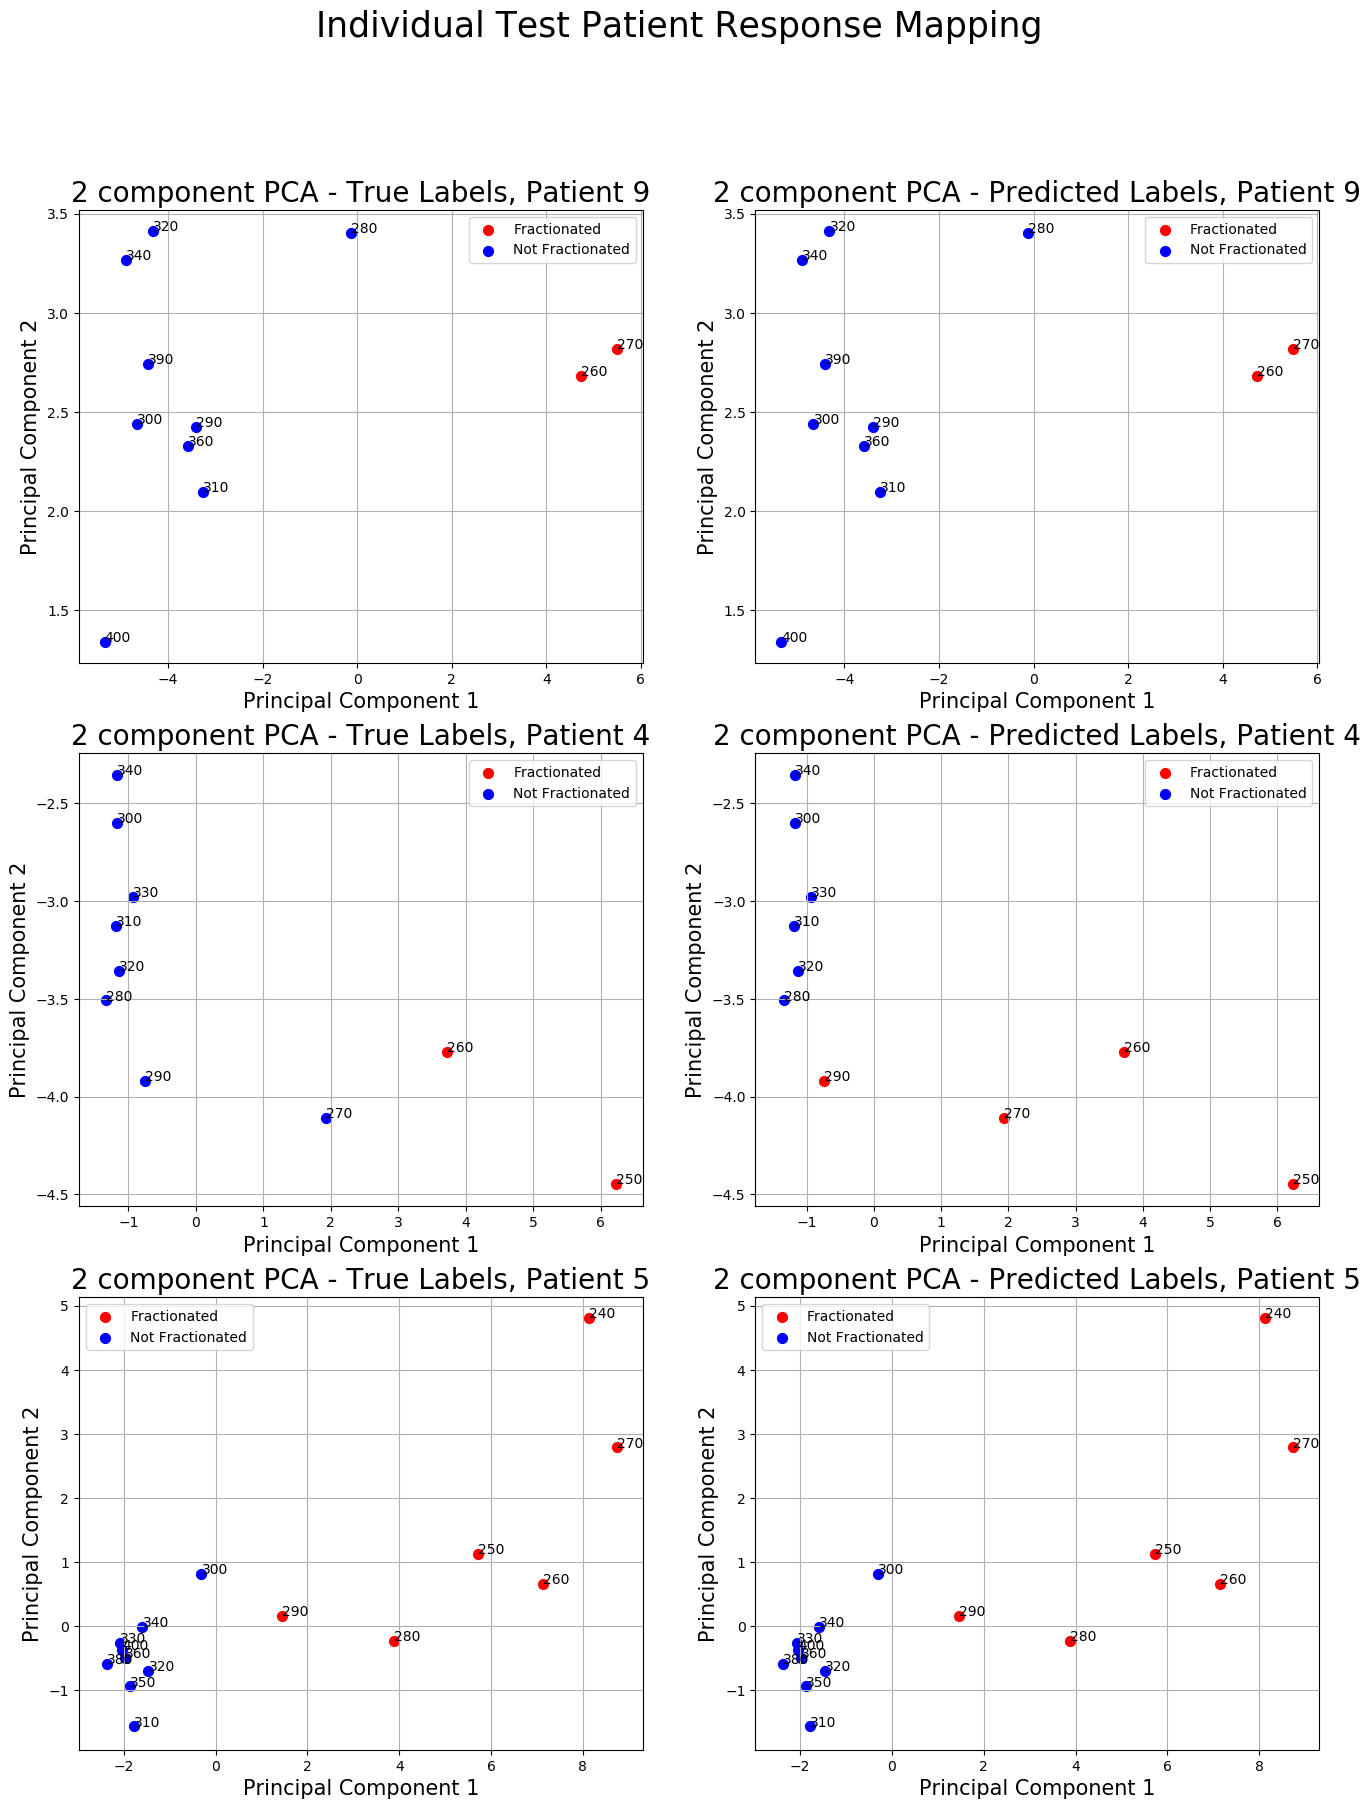

In [114]:
fig, axes = plt.subplots(nrows=len(test_patients), ncols=2, figsize = (16,20))

labels = [1, 0]
colors = ['r', 'b']

for i, patient in enumerate(test_patients):
    axes[i][0].set_xlabel('Principal Component 1', fontsize = 15)
    axes[i][0].set_ylabel('Principal Component 2', fontsize = 15)
    axes[i][0].set_title('2 component PCA - True Labels, Patient ' + patient, fontsize = 20)
    axes[i][1].set_xlabel('Principal Component 1', fontsize = 15)
    axes[i][1].set_ylabel('Principal Component 2', fontsize = 15)
    axes[i][1].set_title('2 component PCA - Predicted Labels, Patient ' + patient, fontsize = 20)
    pca_patient = final_df_real[final_df_real['Patient']==patient]
    for label, color in zip(labels,colors):
        idx_to_keep = (pca_patient['Label'].values == label)
        axes[i][0].scatter(pca_patient.loc[idx_to_keep, 'principal component 1']
                   , pca_patient.loc[idx_to_keep, 'principal component 2']
                   , c = color
                   , s = 50)
        
        idx_to_keep = (pca_patient['XGBoost Predictions'].values == label)
        axes[i][1].scatter(pca_patient.loc[idx_to_keep, 'principal component 1']
               , pca_patient.loc[idx_to_keep, 'principal component 2']
               , c = color
               , s = 50)
        
        for _,row in pca_patient[idx_to_keep].iterrows():
            axes[i][0].annotate(row['Coupling Interval'], 
                                (row['principal component 1'], row['principal component 2']))
            
            axes[i][1].annotate(row['Coupling Interval'], 
                                (row['principal component 1'], row['principal component 2']))
        
    axes[i][0].legend(['Fractionated', 'Not Fractionated'])
    axes[i][0].grid()
    axes[i][1].legend(['Fractionated', 'Not Fractionated'])
    axes[i][1].grid()
    
plt.suptitle('Individual Test Patient Response Mapping', fontsize=25)
plt.show()